In [1]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D,GlobalAvgPool2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils

In [3]:
# Create Directory for Training Data

os.mkdir("./contents/Crop-Brain-MRI")
os.mkdir("./contents/Crop-Brain-MRI/glioma_tumor")
os.mkdir("./contents/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("./contents/Crop-Brain-MRI/pituitary_tumor")

In [4]:
# Create Directory for Testing Data

os.mkdir("./contents/Test-Brain-MRI")
os.mkdir("./contents/Test-Brain-MRI/glioma_tumor")
os.mkdir("./contents/Test-Brain-MRI/meningioma_tumor")
os.mkdir("./contents/Test-Brain-MRI/pituitary_tumor")

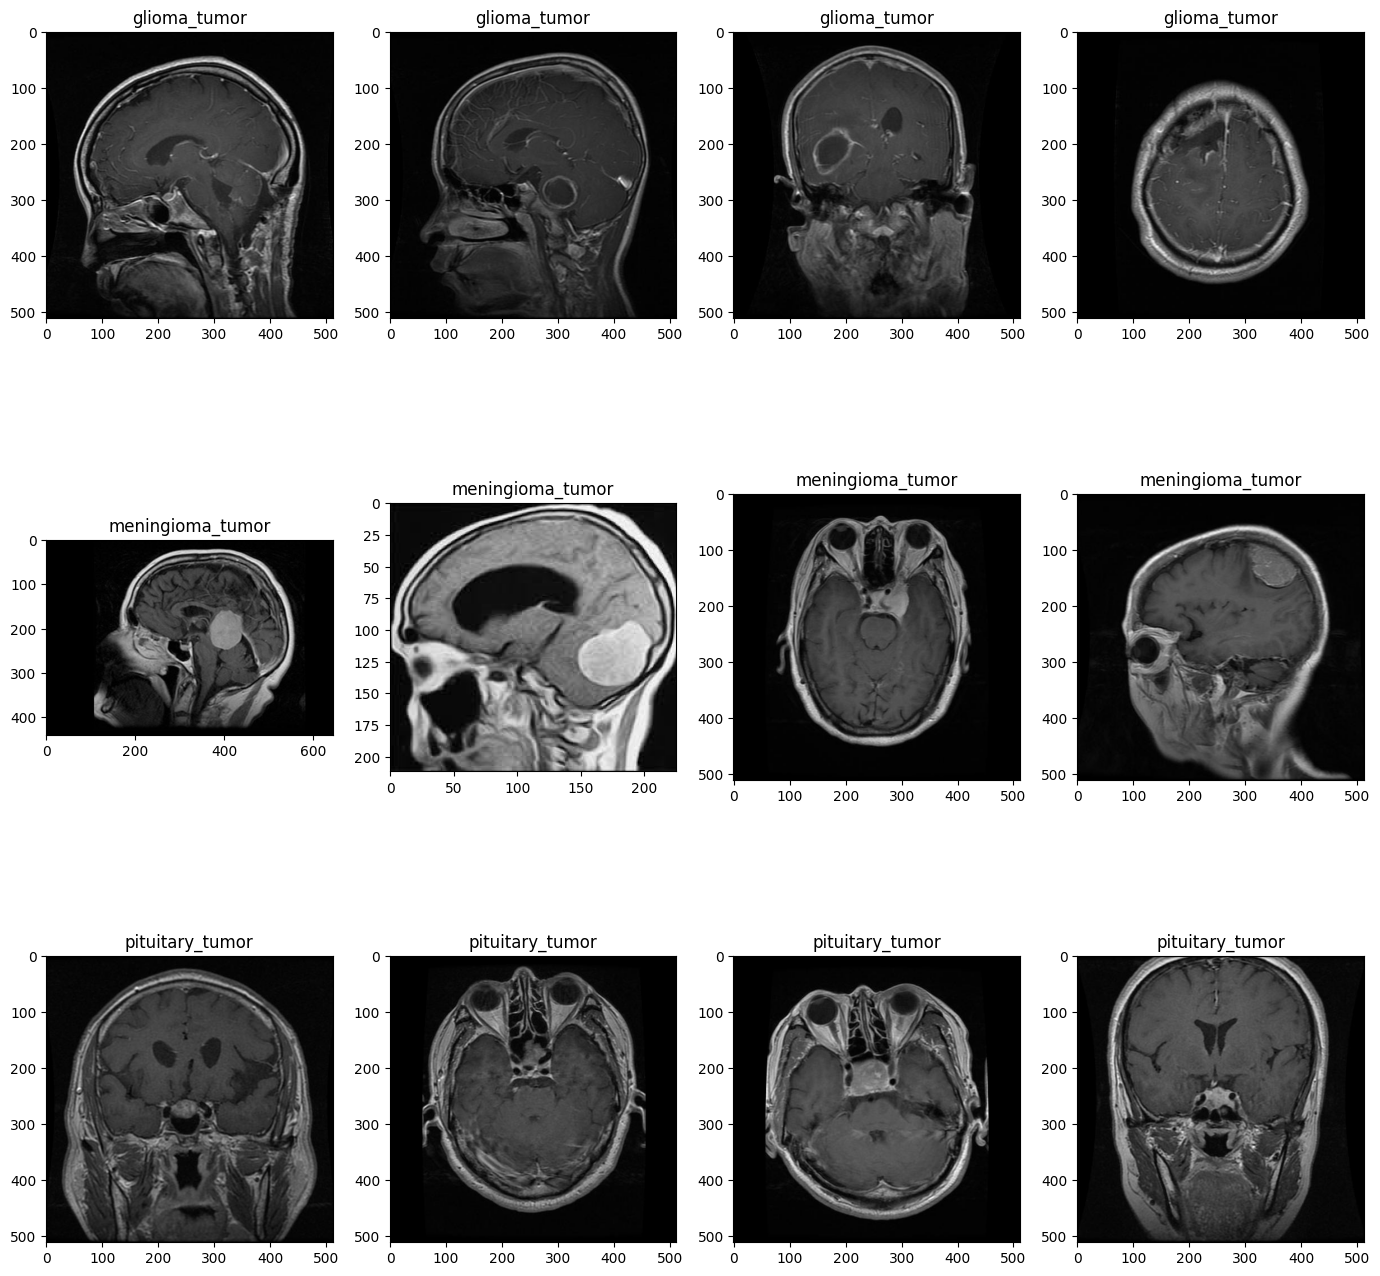

In [5]:
# Data Visualisation

train_dir = "./contents/Training/"
test_dir = "./contents/Testing/"

classes = os.listdir("./contents/Training")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(3, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [49]:
# def preprocess_and_segmentation(img,plot=False):
#     ogimg=img
#     #     1. PreProcessing
#     # **********************GrayScaling****************************
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
#     # ********************Filtering (Gaussian Filter) **************
#     gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
       
        
#     #    2. Segmentation     
#     # ********************Thresholding Segmentation*****************
#     ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#     # ********************Watershed Segmentation********************
        
#     kernel = np.ones((3,3),np.uint8)
#     opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

#     # Finding sure background area
#     sure_bg = cv2.dilate(thresh,kernel,iterations=3)

#     # Finding sure foreground area
#     dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
#     ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

#     # Finding unknown region
#     sure_fg = np.uint8(sure_fg)
#     unknown = cv2.subtract(sure_bg,sure_fg)

#     # Marker labelling
#     ret, markers = cv2.connectedComponents(sure_fg)

#     # Add one to all labels so that sure background is not 0, but 1
#     markers = markers+1


#     # Now, mark the region of unknown with zero
#     markers[unknown==255] = 0
#     markers = cv2.watershed(img,markers)
#     img[markers == -1] = [255,0,0]

#     im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
#     if plot:
#         plt.figure()
#         plt.subplot(1, 2, 1)
#         plt.imshow(ogimg)
#         plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
#         plt.title('Original Image')
#         plt.subplot(1, 2, 2)
#         plt.imshow(im1)
#         plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
#         plt.title('Preprocessed Image')
#         plt.show()
    
#     return img



def preprocess_and_segmentation(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

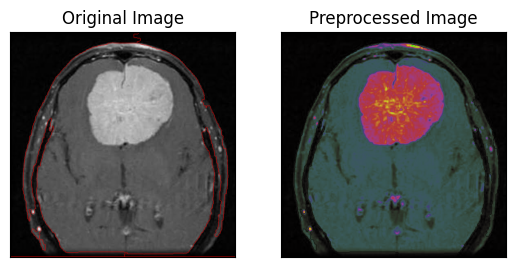

In [50]:
# Check the crop

example_img = cv2.imread("./contents/Training/meningioma_tumor/image(2).jpg")
cropped_image_example = preprocess_and_segmentation(example_img, plot=True)

In [51]:
# Crop the Training Images and Save to respective directories
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Crop-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Crop-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "./contents/Crop-Brain-MRI/pituitary_tumor/"+str(j)+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|████████████████████████████████████████████████████████████████████████████████| 901/901 [00:34<00:00, 26.29it/s]


In [52]:
# Crop the Testing Images and Save to respective directories
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Test-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Test-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "./contents/Test-Brain-MRI/pituitary_tumor/"+str(j)+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.50it/s]


In [53]:
# Use Image Data Generator

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('./contents/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')

valid_data = datagen.flow_from_directory('./contents/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')

test_data = datagen.flow_from_directory('./contents/Test-Brain-MRI/', target_size=(224,224), class_mode='categorical')

Found 2212 images belonging to 3 classes.
Found 552 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [54]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}


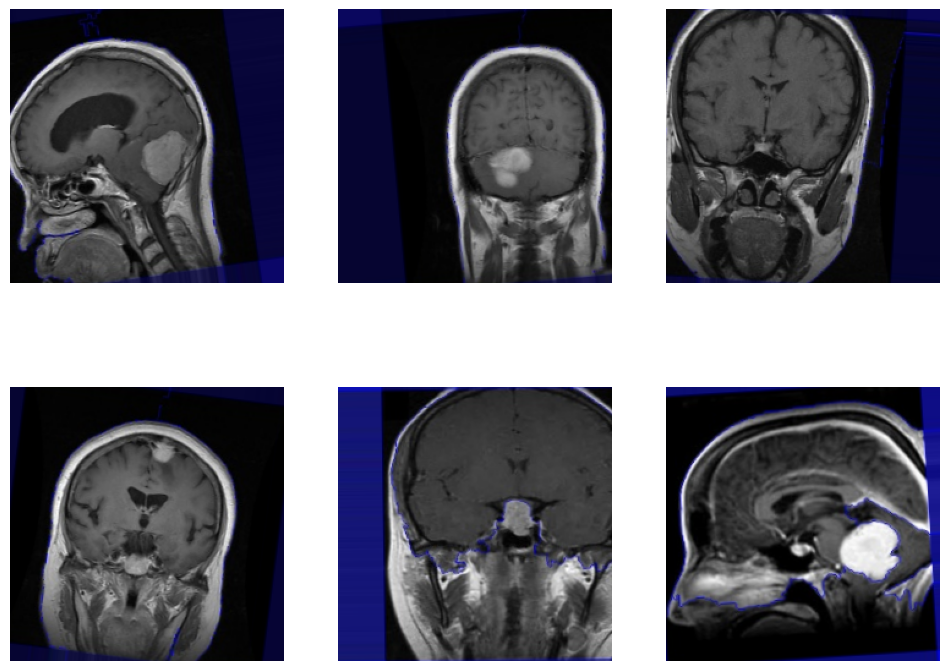

In [55]:
# View the augmented data

sample_x, sample_y =next(train_data)
plt.figure(figsize=(12,9))
for i in range (6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)  
plt.show()

In [56]:
# Build the Model

cnn=tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64,padding='same',strides=2,kernel_size=3,activation='relu',input_shape=[224,224,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(3,activation='softmax'))


In [57]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [58]:
elst=EarlyStopping(monitor='val_loss',patience=5,mode='min')
save_ck=ModelCheckpoint('classification_model.hdf5',save_best_only=True,monitor='val_loss',mode='min')

In [59]:
cnn.fit(train_data,validation_data=valid_data,callbacks=[save_ck],epochs=25)

Epoch 1/25
70/70 [==============================] - 99s 1s/step - loss: 130.4660 - accuracy: 0.4195 - val_loss: 3.4226 - val_accuracy: 0.4565
Epoch 2/25
70/70 [==============================] - 79s 1s/step - loss: 2.0528 - accuracy: 0.5488 - val_loss: 1.6245 - val_accuracy: 0.4674
Epoch 3/25
70/70 [==============================] - 75s 1s/step - loss: 1.1816 - accuracy: 0.6013 - val_loss: 1.5690 - val_accuracy: 0.4855
Epoch 4/25
70/70 [==============================] - 76s 1s/step - loss: 1.0785 - accuracy: 0.6171 - val_loss: 1.2893 - val_accuracy: 0.5091
Epoch 5/25
70/70 [==============================] - 79s 1s/step - loss: 0.9667 - accuracy: 0.6456 - val_loss: 1.2808 - val_accuracy: 0.4638
Epoch 6/25
70/70 [==============================] - 77s 1s/step - loss: 0.9037 - accuracy: 0.6465 - val_loss: 1.4638 - val_accuracy: 0.4620
Epoch 7/25
70/70 [==============================] - 77s 1s/step - loss: 0.8835 - accuracy: 0.6605 - val_loss: 1.2633 - val_accuracy: 0.5181
Epoch 8/25
70/70 [

In [60]:
# Evaluate the model on Test Set

cnn.evaluate(test_data)

1/1 [==============================] - 0s 275ms/step - loss: 0.8158 - accuracy: 0.6667


[0.8157591223716736, 0.6666666865348816]

1/1 [==============================] - 0s 32ms/step
pituitary_tumor


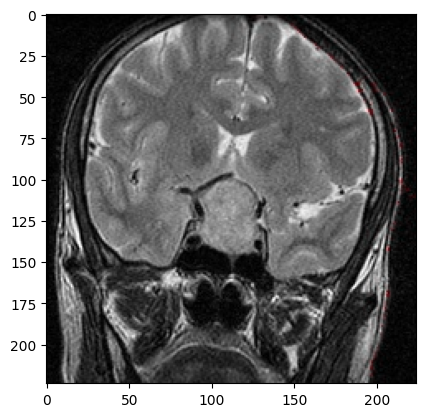

In [66]:
# Obtain Prediction on Test Image

class_dict = {0: "glioma_tumor", 1: "meningioma_tumor" , 2: "pituitary_tumor"}

test_img1 = cv2.imread("./contents/Crop-Brain-MRI/pituitary_tumor/27.jpg")

plt.imshow(test_img1)

plt.grid(False)

test_img1 = np.expand_dims(test_img1, axis=0)

pred = cnn.predict(test_img1)
pred = np.argmax(pred)
pred_class =class_dict[pred]
print(pred_class)